In [21]:
import sys

sys.path.append("../")

import pennylane as qml
import pennylane.numpy as np
from main import *

np.random.seed(0)  # For reproducibility

In this notebook we present the syntaxis to create and evaluate quantum states and operators in first quantization in a qubit-based quantum computer.

In the first place let us define the number of qubits and the device to perform the simulations.

In [22]:
num_wires = 3
dev = qml.device( 'lightning.qubit', wires=2*num_wires )

Second, we create discrete versions of the position operator $X$ and the momentum operator $P$ between $x_{min}=-5$ and $x_{max}=5$ with the function ```X_and_P_ops``` 

In [23]:
X, P = X_and_P_ops(range(num_wires), x_min=-5, x_max=5)
X, P

(<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>)

We now will evaluate the expected value of those operators in a random quantum state $|\psi\rangle$.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

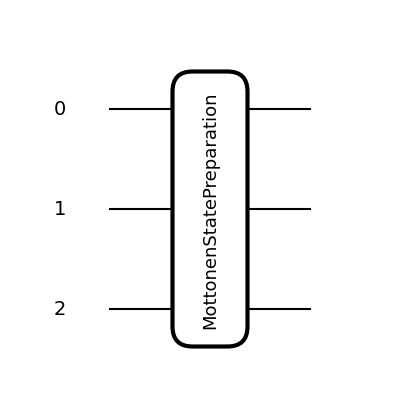

In [24]:
def psi(params):
    qml.MottonenStatePreparation(params, range(num_wires))


params = np.random.randn(2**num_wires) + 1j * np.random.randn(2**num_wires)
params = params / np.linalg.norm(params)

qml.draw_mpl(psi)(params)

In [25]:
print( params )

[ 0.41768427-0.02443969j  0.0947474 +0.09721964j  0.23174112+0.03410598j
  0.53058848+0.34433625j  0.44219187+0.18019504j -0.2313954 +0.02880966j
  0.2249576 +0.10509591j -0.03583767+0.07900589j]


We can evaluate the expecting value of $X$ or $P$ over $|\psi\rangle$ creating the corresponding __quantum tape__ with the function ```tapes_expval_XP```. This function has two outputs: the tapes and a function that takes the probabilities over these tapes to obtain the expected value.

In [26]:
tape_X, fun_X = tapes_expval_XP(params, psi, X)
print(tape_X[0].draw())

0: ──RY─╭●─────╭●────────╭●────────────╭●──RZ─╭●─────╭●────────╭●────────────╭●─┤ ╭Probs
1: ──RY─╰X──RY─╰X─╭●─────│──────╭●─────│───RZ─╰X──RZ─╰X─╭●─────│──────╭●─────│──┤ ├Probs
2: ──RY───────────╰X──RY─╰X──RY─╰X──RY─╰X──RZ───────────╰X──RZ─╰X──RZ─╰X──RZ─╰X─┤ ╰Probs


The expected value is executing the tapes and employing the postprocessing function.

In [27]:
probs_X = qml.execute( tape_X, dev )
fun_X( probs_X )

-0.8072673075874343

We can also directly obtain the expected value using the function ```expval_XP```.

In [28]:
expval_XP(params, psi, X, dev)

-0.8072673075874343

For the evaluation of $P$, the tape includes the Fourier Transfom to change the basis from the eigenbasis of $X$ to the eigenbasis of $P$.

In [29]:
tape_P, fun_P = tapes_expval_XP(params, psi, P)
print(tape_P[0].draw())

0: ──RY─╭●─────╭●────────╭●────────────╭●──RZ─╭●─────╭●────────╭●────────────╭●──Rϕ──RX──Rϕ──Rϕ─╭●
1: ──RY─╰X──RY─╰X─╭●─────│──────╭●─────│───RZ─╰X──RZ─╰X─╭●─────│──────╭●─────│──────────────────╰X
2: ──RY───────────╰X──RY─╰X──RY─╰X──RY─╰X──RZ───────────╰X──RZ─╰X──RZ─╰X──RZ─╰X───────────────────

──────╭●──Rϕ─╭●─────╭●───────────────────────────────────────────┤ ╭Probs
───Rϕ─╰X──Rϕ─│──────│───Rϕ──RX──Rϕ──Rϕ─╭●─────╭●─────────────────┤ ├Probs
─────────────╰X──Rϕ─╰X──Rϕ─────────────╰X──Rϕ─╰X──Rϕ──Rϕ──RX──Rϕ─┤ ╰Probs


In [30]:
probs_P = qml.execute( tape_P, dev )
fun_P( probs_P )

-0.33213096824813393

Setting the input ```semiclassical=True``` of ```X_and_P_ops```, the evaluation of $P$ is performed with a semiclassical implementation of the Fourier transform. This replaces the controlled operations with mid-circuit measurements and classical controls, thus reducing the depth of the quantum circuit.

In [31]:
X_sc, P_sc = X_and_P_ops(range(num_wires), -5, 5, semiclassical=True)
tape_P_sc, fun_P_sc = tapes_expval_XP(params, psi, P_sc)
print(tape_P_sc[0].draw())

0: ──RY─╭●─────╭●────────╭●────────────╭●──RZ─╭●─────╭●────────╭●────────────╭●──Rϕ──RX──Rϕ──┤↗├────
1: ──RY─╰X──RY─╰X─╭●─────│──────╭●─────│───RZ─╰X──RZ─╰X─╭●─────│──────╭●─────│────────────────║───Rϕ
2: ──RY───────────╰X──RY─╰X──RY─╰X──RY─╰X──RZ───────────╰X──RZ─╰X──RZ─╰X──RZ─╰X───────────────║───║─
                                                                                              ╚═══╩═
                                                                                                    

───────────────────────────────────┤ ╭Probs
───Rϕ──RX──Rϕ──┤↗├─────────────────┤ ├Probs
───Rϕ───────────║───Rϕ──Rϕ──RX──Rϕ─┤ ╰Probs
═══╝            ║   ║                      
                ╚═══╝                      


We show a better plot of the Fourier Transform from our implementation of the operation `QFT`, in the standard manner (```semi_classical=False```)

(<Figure size 900x400 with 1 Axes>, <Axes: >)

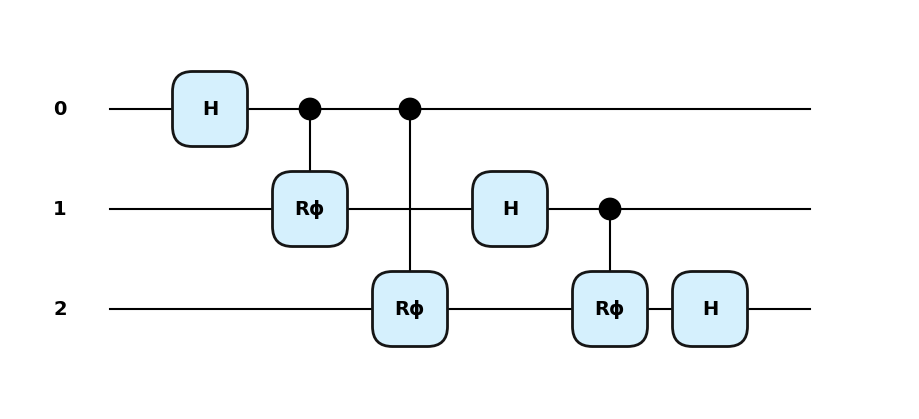

In [32]:
qft = QFT(range(num_wires), semi_classical=False)


def fun():
    qft.decomposition()


qml.draw_mpl(fun, style="pennylane")()

and using the semiclassical variation

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

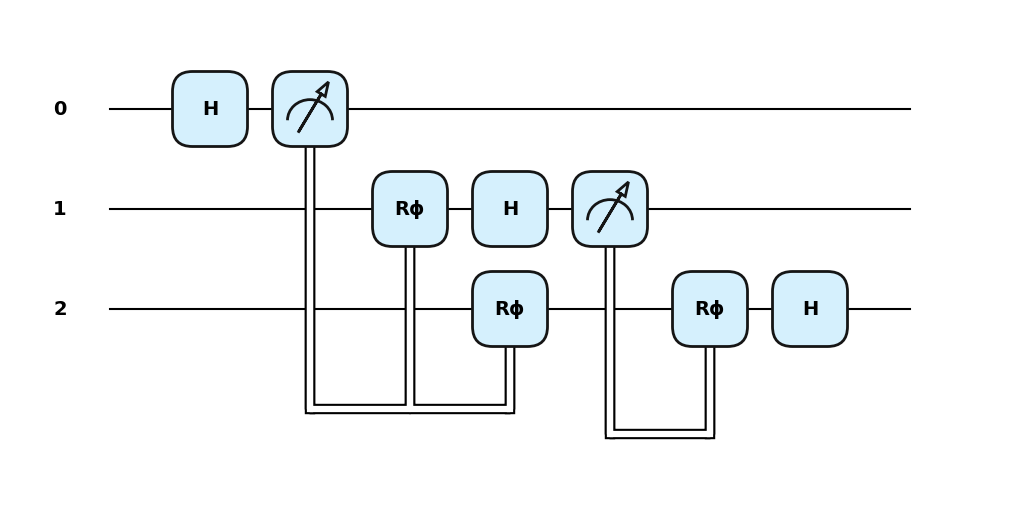

In [33]:
qft = QFT(range(num_wires), semi_classical=True)


def fun():
    qft.decomposition()


qml.draw_mpl(fun, style="pennylane")()

These circuits give the same expected value as the standard implementation. The ```lightning device``` does not support natively mid-circuit measurements, which are used in the semi-classical QFT. In order to simulate semi-classical QFT with ```lighting device```, we have to transform the mid-circuit measurements of the tapes into C-NOTs and auxiliary qubits with the function ```qml.defer_measurements```. 

In [34]:
tape_P_sc_defer = [ qml.defer_measurements(tape)[0][0] for tape in tape_P_sc ]
probs_P_sc = qml.execute( tape_P_sc_defer, dev )
fun_P_sc( probs_P_sc )

-0.33213096824813393

This is done automatically in the function ```expval_XP```.

In [35]:
expval_XP(params, psi, P_sc, dev )

-0.33213096824813393

We can also evaluate arbitrary quadrature operator $Q=aX+bP$ puting each term of the sum in a ```list```.

In [36]:
a = 1
b = 1

Q = [X.s_prod(a), P.s_prod(b)]
Q

[<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>]

In this case the program perform a simulation for each term in the list.

In [37]:
expval_XP(params, psi, Q, dev)

-1.139398275835568

We can also evaluate the gradient of ```exp_val_XP```.

In [38]:
grad_XP( params, psi, Q, dev )

tensor([ 1.48597445,  1.74389913,  1.12901019,  0.65356724, -0.25067299,
        -0.42631781,  0.48396153, -0.3001442 ], requires_grad=True)